# Shows results for example image of wheat plot

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from PIL import Image

import import_ipynb
import wheat_dataset
from wheat_dataset import WheatDataset

from utils_dataset import get_transform_albumentation, get_transform_imgaug_img, get_transform_torch_img
from detection_transforms import Compose, PILToTensor, ConvertImageDtype, RandomHorizontalFlip
from detection_utils import collate_fn

import torch
import torchvision
from torchvision import transforms as T
from torchvision.utils import draw_segmentation_masks
from torchvision.utils import draw_bounding_boxes
import torchvision.ops as ops

import numpy as np
import math
import copy
import cv2
import os

importing Jupyter notebook from wheat_dataset.ipynb
Seed set!


# Functions

In [3]:
# prediction of model   ->    returns dictionary
def predict_image_window(model, image_window, score_threshold):
    # prediction
    image_window = Image.fromarray(image_window)
    image_window = get_transform_torch_img(image_window) / 255
    prediction = model([image_window.cuda()])

    # save as tensor
    prediction[0]["boxes"] = torch.Tensor(prediction[0]["boxes"].cpu().detach().numpy())
    prediction[0]["scores"] = torch.Tensor(prediction[0]["scores"].cpu().detach().numpy())
    prediction[0]["labels"] = torch.Tensor(prediction[0]["labels"].cpu().detach().numpy())
    prediction[0]["masks"] = torch.Tensor(prediction[0]["masks"].cpu().detach().numpy())

    # remove predictions with small probability (score_threshold)
    prediction[0]["boxes"] = prediction[0]["boxes"][prediction[0]["scores"] > score_threshold]
    prediction[0]["labels"] = prediction[0]["labels"][:len(prediction[0]["boxes"])]
    prediction[0]["masks"] = prediction[0]["masks"][prediction[0]["scores"] > score_threshold]
    prediction[0]["scores"] = prediction[0]["scores"][:len(prediction[0]["boxes"])]

    return prediction[0]

In [4]:
# calculate center and pixel area of bounding boxes   ->  returns x, y and pixel area for bounding boxes as three lists
def get_box_center(boxes):
    x_center, y_center, pixel_areas = [], [], []
    for box in boxes:
        x1, y1, x2, y2 = box
        # calculate values
        x_mid = x1 + ((x2-x1) / 2)
        y_mid = y1 + ((y2-y1) / 2)
        pixel_area = (x2-x1) * (y2-y1)
        # append values to lists
        x_center.append(x_mid)
        y_center.append(y_mid)
        pixel_areas.append(pixel_area)
    return x_center, y_center, pixel_areas

In [5]:
# recalculate predicted boxes on 280x280 images onto position of original 521x1721 image    ->  returns predictions dictionary with updated boxes
def recalculate_bbs(predictions, num_columns):
    for i, pred in enumerate(predictions):
        for j, box in enumerate(pred["boxes"]):
            x1, y1, x2, y2 = box
            # Calculate the row and column index of the current prediction
            row_idx = int(i % (len(predictions) // num_columns))
            col_idx = i // (len(predictions) // num_columns)
            # Calculate the new coordinates based on the row and column index
            new_x1 = x1 + col_idx * 120
            new_y1 = y1 + row_idx * 240
            new_x2 = x2 + col_idx * 120
            new_y2 = y2 + row_idx * 240
            pred["boxes"][j] = torch.stack([new_x1, new_y1, new_x2, new_y2])
    return predictions

In [6]:
def remove_overlapping_boxes(predictions, iou_threshold=0.5):

    # Collect boxes, masks and associated sub-image in a list
    boxes_mask_list = []
    for i, prediction in enumerate(predictions):
        for j, boxes in enumerate(prediction["boxes"]):
            boxes_mask_list.append((boxes, prediction["masks"][j], i))

    boxes = [torch.clone(prediction['boxes']) for prediction in predictions]
    scores = [torch.clone(prediction['scores']) for prediction in predictions]
    masks = [torch.clone(prediction['masks']) for prediction in predictions]

    # Concat all values
    boxes = torch.cat(boxes)
    scores = torch.cat(scores)
    masks = torch.cat(masks)

    # Apply NMS to the boxes
    keep = ops.nms(boxes, scores, iou_threshold)

    # Filter out boxes and scores that didn't meet the score threshold
    boxes = boxes[keep]
    scores = scores[keep]
    masks = masks[keep]
    boxes_mask_list = [boxes_mask_list[i] for i in keep]

    # Return the filtered boxes, scores, and masks as a dictionary
    predictions = {
        'scores': scores,
        'boxes': boxes,
        'association': boxes_mask_list
    }

    return predictions

In [7]:
# reconstructs mask for 520x1720 image and to filter for later purposes    ->     returns tensor of masks
def create_mask(predictions, sub_image_count, num_columns):
    new_mask = []
    transform_pil = T.ToPILImage()
    transform_tensor = T.ToTensor()

    # association[0] = mask, association[1] = sub-image-nr
    for association in predictions['association']:
        i = int(association[2])
        for mask in association[1]:
            tmp = Image.new("L", (521, 1721))
            mask = transform_pil(mask)
            index = i % int(sub_image_count/num_columns)
            # 1st row:      i < 7
            if i < (sub_image_count / num_columns):
                tmp.paste(mask, (0, index*mask.size[1] - index*40))
            # 2nd row:      i >= 7 AND i < 14
            if (i >= (sub_image_count / num_columns)) and (i <(sub_image_count / num_columns * 2)):
                tmp.paste(mask, ((mask.size[1]-140) - 20, index*mask.size[1] - index*40))
            # 3rd row:      i >= 14
            if i >= (sub_image_count / num_columns * 2):
                tmp.paste(mask, (mask.size[1] - 40, index*mask.size[1] - index*40))
            new_mask.append(transform_tensor(tmp))
    new_mask = torch.stack(new_mask)
    del tmp
    return new_mask

# Main Function and Plots

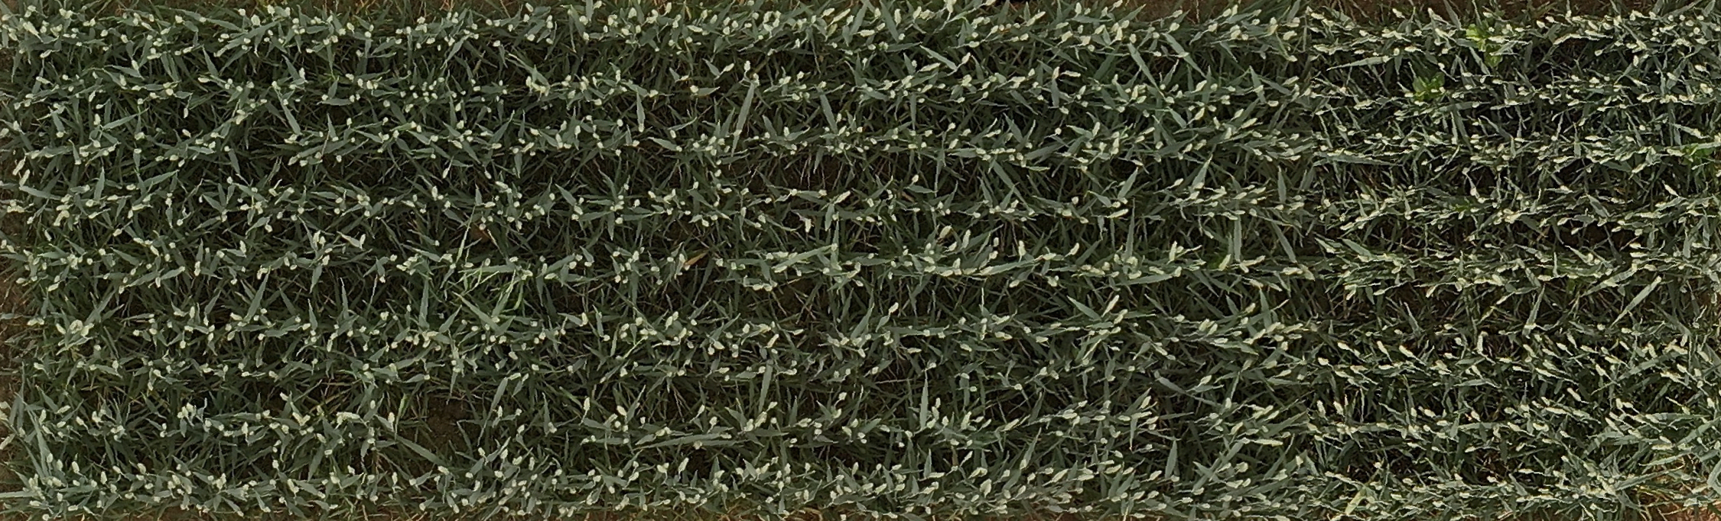

In [86]:
model_path = "/home/emj6571/model/model_5_epochs_2022-12-14_v2.pt"
model = torch.load(model_path)

# image_path = "/home/emj6571/dataset_aehren/full_plots/test_file_big_1.jpg"
image_path = '/data/departments/schoen/roessle/HSWT_Aehrenzaehlen/images_full_plots/DOP_AD22_HZ_D10_RGB_18mm_UTM32_____multi_band___parcel_10108_buff_0.0.tif'
im = Image.open(image_path)
im = im.rotate(85, expand=True)

# (left,top), (right,bottom)
im = im.crop((350, 325, 2600, 1025))
im = im.resize(size=(1721, 521))

image = np.array(im)
image_window = image[280:560, 120:400, :]
image = image.transpose(1,0,2)

# image = cv2.imread(image_path)
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# image = cv2.resize(image, dsize=(521, 1721))
image_window = image[520:800, 120:400, :]
im

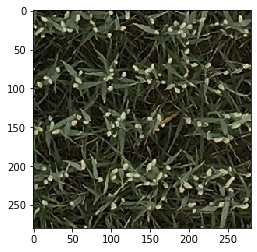

In [53]:
plt.imshow(image_window.transpose(1,0,2), interpolation='nearest')
plt.show()

In [55]:
score_threshold = 0.7
iou_threshold = 0.2
mask_threshold = 0.5

In [ ]:
# def main(model, image, score_threshold, iou_threshold, mask_threshold):
#     COLORS = [(255,0,0), (0,255,0), (0,0,255)]
#     counter = 0

#     # sliding window 
#     images = []
#     tmp = image
#     step_size_width = 120
#     step_size_heigth = 240
#     num_columns = math.floor(image.shape[1] / (280-120))
#     (w_width, w_height) = (280, 280)
#     for x in range(0, image.shape[1] - w_width , step_size_width):       # width
#         for y in range(0, image.shape[0] - w_height, step_size_heigth):    # heigth
#             image_window = image[y:y + w_height, x:x + w_width, :]
#             images.append(image_window)
#             # cv2.rectangle(tmp, (x, y), (x + w_width, y + w_height), COLORS[counter], 2)   # show sub-image crops
#         counter += 1
#     sub_image_count = len(images)

#     # predictions for sliding window     
#     predictions = []
#     for i, image in enumerate(images, start=1):
#         prediction = predict_image_window(model, image, score_threshold)
#         predictions.append(prediction)

#     predictions = recalculate_bbs(predictions, num_columns)
    
#     old_boxes = []
#     for pred in predictions:
#         old_boxes.append(pred["boxes"])

#     predictions = remove_overlapping_boxes(predictions, iou_threshold)
#     x_filtered, y_filtered, pixel_areas = get_box_center(predictions["boxes"])

#     # create mask
#     mask = create_mask(predictions, sub_image_count, num_columns)
#     mask = mask.sum(dim=0) > mask_threshold

#     n_wheatheads = len(predictions["boxes"])

#     return images, predictions, n_wheatheads, predictions["boxes"], x_filtered, y_filtered, mask, pixel_areas, old_boxes

In [71]:
def main(model, image, score_threshold, iou_threshold, mask_threshold):
    COLORS = [(255,0,0), (0,255,0), (0,0,255)]
    counter = 0

    # sliding window 
    images = []
    tmp = image
    step_size_width = 120
    step_size_heigth = 240
    num_columns = math.floor(image.shape[1] / (280-120))
    (w_width, w_height) = (280, 280)
    image_window = image[520:800, 120:400, :]
    images.append(image_window)
            # cv2.rectangle(tmp, (x, y), (x + w_width, y + w_height), COLORS[counter], 2)   # show sub-image crops
    counter += 1
    sub_image_count = len(images)

    # predictions for sliding window     
    predictions = []
    for i, image in enumerate(images, start=1):
        prediction = predict_image_window(model, image, score_threshold)
        predictions.append(prediction)

    # predictions = recalculate_bbs(predictions, num_columns)
    
    old_boxes = []
    for pred in predictions:
        old_boxes.append(pred["boxes"])

    predictions = remove_overlapping_boxes(predictions, iou_threshold)
    x_filtered, y_filtered, pixel_areas = get_box_center(predictions["boxes"])

    # create mask
    # mask = create_mask(predictions, sub_image_count, num_columns)
    # mask = mask.sum(dim=0) > mask_threshold
    mask = None

    n_wheatheads = len(predictions["boxes"])

    return images, predictions, n_wheatheads, predictions["boxes"], x_filtered, y_filtered, mask, pixel_areas, old_boxes, image_window

In [72]:
images, predictions, n_wheatheads, filtered_boxes, x_filtered, y_filtered, filtered_mask, pixel_areas, old_boxes, image_window = main(model, 
                                                                                                                    image, 
                                                                                                                    score_threshold,
                                                                                                                    iou_threshold, 
                                                                                                                    mask_threshold)

# Plot of Image Predictions

In [76]:
# Plot image prediction
def image_plot(image, filtered_x, filtered_y, filtered_boxes, filtered_mask, image_window):
    image = image.transpose(1,0,2)
    total_wheatheads = len(filtered_x)

    transform = T.Compose([T.ToTensor(), T.ConvertImageDtype(torch.uint8)])
    torch_img = transform(image_window.transpose(1,0,2))

    torch_img_boxes = draw_bounding_boxes(torch_img.permute(0,2,1), filtered_boxes, colors=(255,0,0))
    # torch_img_masks = draw_segmentation_masks(torch_img_boxes, filtered_mask, colors=(0,0,255), alpha=0.5).permute(2,1,0)

    # Plots normal image with boxes
    print(f"Total Wheat Heads: {total_wheatheads}")
    f1 = plt.figure(figsize=(30,16))
    ax = f1.add_subplot(1,1,1)
    plt.title(f"Full Plot - Wheat count: {total_wheatheads}", fontsize=20)
    implot1 = plt.imshow(torch_img_boxes.permute(2,1,0))
    plt.show(block=True)

Total Wheat Heads: 132


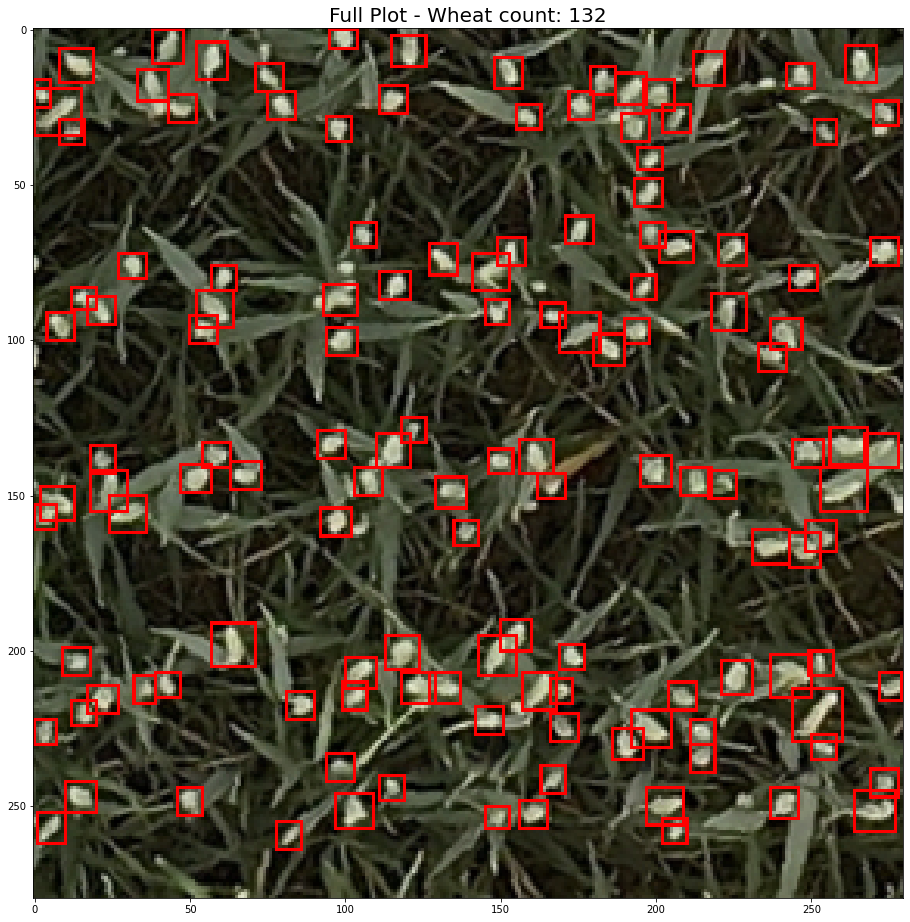

In [77]:
image_plot(image, x_filtered, y_filtered, filtered_boxes, filtered_mask, image_window)

In [14]:
def get_grid_counts(x_filtered, y_filtered, gridsize_heatmap, cells_w, cells_h):
    # Convert x and y coordinates to NumPy arrays
    x_filtered = np.array(x_filtered)
    y_filtered = np.array(y_filtered)
    
    # Calculate the indices of the grid cells for each point
    x_indices = np.floor(x_filtered / gridsize_heatmap).astype(int)
    y_indices = np.floor(y_filtered / gridsize_heatmap).astype(int)
    
    # Create a 2D array of zeros to store the counts for each grid cell
    grid_counts = np.zeros((cells_w, cells_h), dtype=int)
    
    # Increment the count for each grid cell that contains a point
    for x, y in zip(x_indices, y_indices):
        grid_counts[y][x] += 1
    
    # Transpose the array so that the rows correspond to the y axis and the columns correspond to the x axis
    counts = grid_counts.T
    
    return counts

In [15]:
gridsize_heatmap = 40
cells_w = int(1720 / gridsize_heatmap)
cells_h = int(520 / gridsize_heatmap)

In [16]:
np_grid = get_grid_counts(x_filtered, y_filtered, gridsize_heatmap, cells_w, cells_h)

# Plot of Heatmaps

In [17]:
# Plots count (and density) heatmap
def heatmaps(image, x_filtered, y_filtered, np_grid, gridsize_heatmap):
    row, column = np_grid.shape
    
    f1 = plt.figure(figsize=(30,16))
    f1.add_subplot(1,1,1)
    heatmap_big = plt.imshow(np_grid, cmap='YlOrRd')
    for i in range(row):
        for j in range(column):
            plt.text(j, i, np_grid[i][j], ha="center", va="center", color="black", fontsize=15)
    plt.title("Count heatmap for image of plot", fontsize=20)
    plt.yticks(ticks=np.arange(row), labels=["y{}".format(i+1) for i in range(row)])
    plt.xticks(ticks=np.arange(column), labels=["x{}".format(i+1) for i in range(column)])
    f1.colorbar(heatmap_big, shrink=0.5)
    plt.show(block=True)

    f2 = plt.figure(figsize=(30,16))
    f2.add_subplot(1,1,1)
    plt.title("Grid with wheat head center points for image of plot", fontsize=20)
    plt.plot(y_filtered, x_filtered, 'ro', markersize=3)
    implot3 = plt.imshow(image.transpose(1,0,2), extent=[0, 1721, 521, 0])
    for x in range(0, 1721, gridsize_heatmap):
        plt.plot([x, x], [0, 521], c='b', linewidth=1)
    for y in range(0, 521, gridsize_heatmap):
        plt.plot([0, 1721], [y, y], c='b', linewidth=1)

    plt.show(block=True)

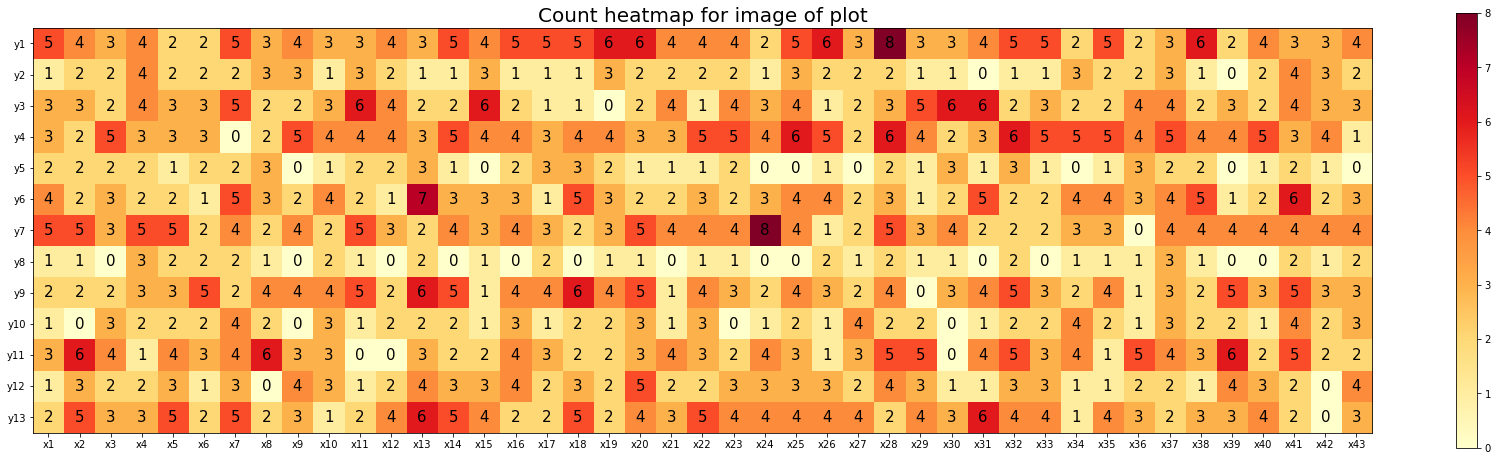

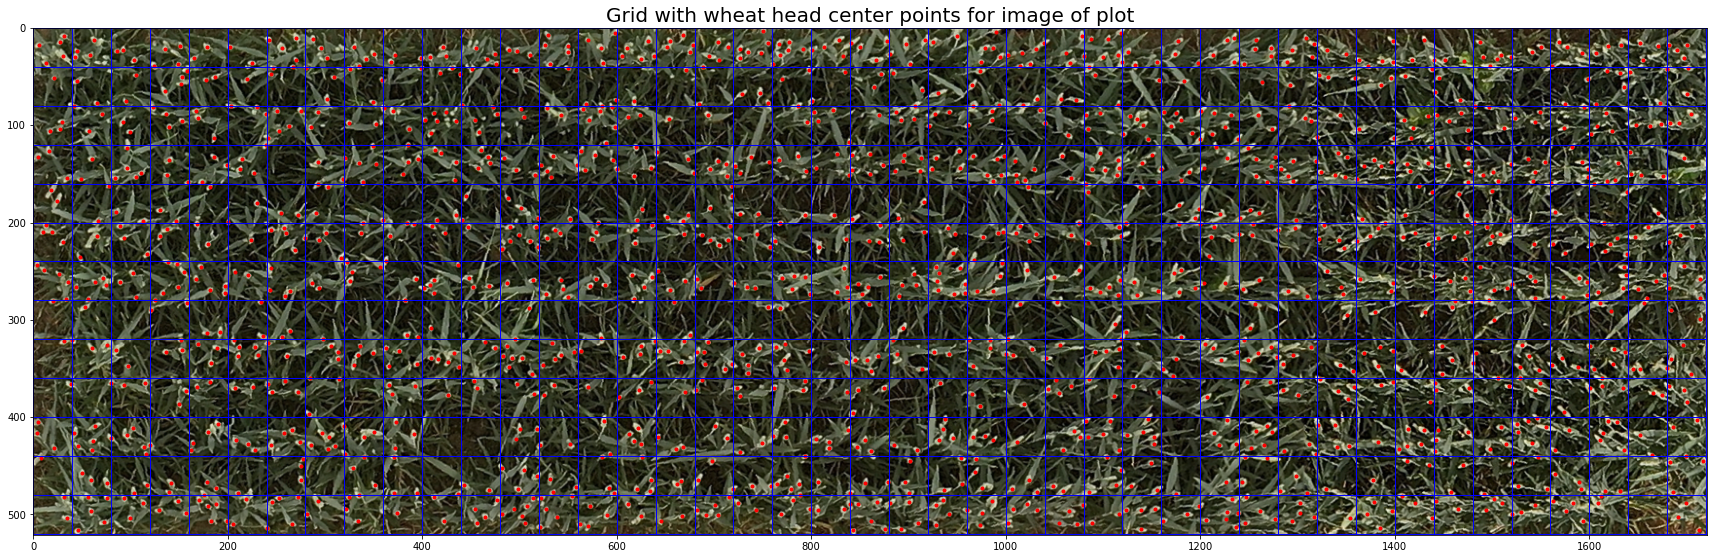

In [18]:
heatmaps(image, x_filtered, y_filtered, np_grid, gridsize_heatmap)

# Plot of gradient density map

In [19]:
# determines wheat heads for each area  ->  returns two lists of seperated x,y centres for each area and the areas themselfs
def density_division(modified_x, modified_y, width, height, WIDTH_PIXELS, HEIGHT_PIXELS, n_areas, pixel_areas, scaling_factor):
    outer_x, middle_x, inner_x = [], [], []
    outer_y, middle_y, inner_y = [], [], []
    outer_area, middle_area, inner_area = 0,0,0

    print(len(pixel_areas))

    for i, x in enumerate(modified_x):
        # outer area
        if x <= WIDTH_PIXELS or x >= (width - WIDTH_PIXELS) or modified_y[i] <= HEIGHT_PIXELS or modified_y[i] >= (height - HEIGHT_PIXELS):
            outer_x.append(x)
            outer_y.append(modified_y[i])
            outer_area += pixel_areas[i]
        # inner area
        elif (x > (n_areas+scaling_factor)*WIDTH_PIXELS and x < width - ((n_areas+scaling_factor)*WIDTH_PIXELS)) and (modified_y[i] > n_areas*HEIGHT_PIXELS and modified_y[i] < height - (n_areas*HEIGHT_PIXELS)):
            inner_x.append(x)
            inner_y.append(modified_y[i])
            inner_area += pixel_areas[i]
        # middle area
        else:
            middle_x.append(x)
            middle_y.append(modified_y[i])
            middle_area += pixel_areas[i]

    return [outer_x, middle_x, inner_x], [outer_y, middle_y, inner_y], [outer_area, middle_area, inner_area]

In [20]:
# plots gradient density map
def plot_gradient_density(image, filtered_boxes, x_filtered, y_filtered, filtered_mask, pixel_areas):
    image = image.transpose(1,0,2)
    height, width, channels = image.shape

    WIDTH_PIXELS = math.floor(width*0.06)
    HEIGHT_PIXELS = math.floor(height*0.1)
    COLORS = ['ro', 'bo', 'mo']
    n_areas = 2
    scaling_factor = 1.44

    x, y, areas = density_division(y_filtered, x_filtered, width, height, WIDTH_PIXELS, HEIGHT_PIXELS, n_areas, pixel_areas, scaling_factor)

    red_c, blue_c, magenta_c = len(x[0]), len(x[1]), len(x[2]) 
    total_wheatheads = red_c + blue_c + magenta_c

    outer = Rectangle((1, 1), width-1, height-1, fill=False, color='r', linewidth=2)
    middle = Rectangle((WIDTH_PIXELS, HEIGHT_PIXELS), width-2*WIDTH_PIXELS, height-2*HEIGHT_PIXELS, fill=False, color='b', linewidth=2)
    inner = Rectangle((WIDTH_PIXELS*(n_areas+scaling_factor), HEIGHT_PIXELS*n_areas), width-n_areas*(n_areas+scaling_factor)*WIDTH_PIXELS, height-n_areas*n_areas*HEIGHT_PIXELS, fill=False, color='m', linewidth=2)

    outer_area = height*width - middle.get_window_extent().width*middle.get_window_extent().height
    middle_area = middle.get_window_extent().width*middle.get_window_extent().height - inner.get_window_extent().width*inner.get_window_extent().height
    inner_area = inner.get_window_extent().width*inner.get_window_extent().height

    # Plots divised image
    print()
    print(f"Division: Each sub-area is about 33% of the total area")
    f = plt.figure(figsize=(30,16))
    ax = f.add_subplot(1,1,1)
    plt.title(f"Density Division Image - Red: {len(x[0])}, Blue: {len(x[1])}, Magenta: {len(x[2])}", fontsize=20)
    for i in range(len(COLORS)):
        plt.plot(x[i], y[i], COLORS[i], markersize=4)
    implot2 = plt.imshow(image, extent=[0, width, height, 0])
    ax.add_patch(outer)
    ax.add_patch(middle)
    ax.add_patch(inner)
    plt.show(block=True)

    # Population Density for each region
    print(f"Magenta: {magenta_c} - {np.round(magenta_c/total_wheatheads*100, 3)}%")
    print(f"Blue: {blue_c} - {np.round(blue_c/total_wheatheads*100, 3)}%")
    print(f"Red: {red_c} - {np.round(red_c/total_wheatheads*100, 3)}%")
    print()
    print(f'Inner population density by count: {np.round(magenta_c/inner_area*100, 3)} wheat heads/pixel')
    print(f'Middle population density by count: {np.round(blue_c/middle_area*100, 3)} wheat heads/pixel')
    print(f'Outer population density by count: {np.round(red_c/outer_area*100, 3)} wheat heads/pixel')
    print()
    print(f'Inner population density by area: {np.round(float(areas[2])/inner_area*100, 3)}%')
    print(f'Middle population density by area: {np.round(float(areas[1])/middle_area*100, 3)}%')
    print(f'Outer population density by area: {np.round(float(areas[0])/outer_area*100, 3)}%')
    print()
    print(f"Total population density by count: {np.round((magenta_c+blue_c+red_c) / (inner_area + middle_area + outer_area) * 100, 3)} wheat heads/pixel")
    print(f"Total population density by area: {np.round((float(areas[2])+float(areas[1])+float(areas[0])) / (inner_area + middle_area + outer_area) * 100, 3)}%")

1538

Division: Each sub-area is about 33% of the total area


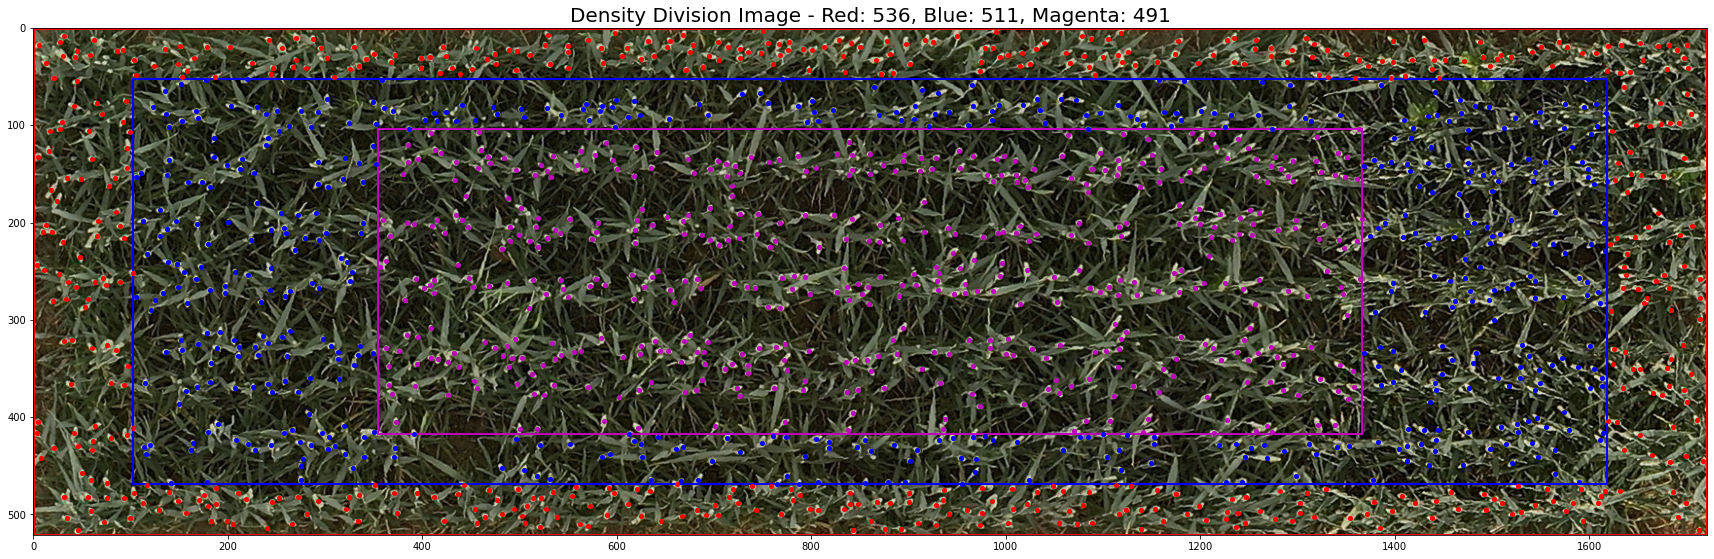

Magenta: 491 - 31.925%
Blue: 511 - 33.225%
Red: 536 - 34.85%

Inner population density by count: 0.155 wheat heads/pixel
Middle population density by count: 0.162 wheat heads/pixel
Outer population density by count: 0.202 wheat heads/pixel

Inner population density by area: 17.914%
Middle population density by area: 18.437%
Outer population density by area: 24.445%

Total population density by count: 0.172 wheat heads/pixel
Total population density by area: 20.027%


In [21]:
plot_gradient_density(image, filtered_boxes, x_filtered, y_filtered, filtered_mask, pixel_areas)